## VAE

In [15]:
import numpy as np
import torch
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

from models.ResVAE import ResVariationalAutoEncoder
from utils.load import load_cw

from matplotlib import pyplot as plt
from utils.geodesicwelding import geodesicwelding

# from utils.get_kl_rate import get_kl_rate

In [92]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MAT_PATH = "data/preprocessed.theta.mat"
MODEL_SAVE_PATH = "checkpoints/ResVAE.pth"
SEED = 717

INPUT_DIM = 100  # Adjusted input dimension to match your complex data
H_DIM = 2000
Z_DIM = 4
H_LAYERS = [2]

NUM_EPOCHS = 2500
BATCH_SIZE = 64  # Adjusted batch size
LR_RATE = 5e-5
KL_RATE = 0.1

torch.manual_seed(SEED)
np.random.seed(SEED)

In [93]:
cw = load_cw(MAT_PATH, ["Case00"])
print(cw.shape[0])
cw_tensor = torch.tensor(cw)

train_data = TensorDataset(cw_tensor)
train_loader = DataLoader(
    dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True
)

## Init model
model = ResVariationalAutoEncoder(
    input_dim=INPUT_DIM, h_dim=H_DIM, h_layers=H_LAYERS, z_dim=Z_DIM
).to(DEVICE)
model.initial()

## Load model
# model = torch.load('VAE_theta+bias1.pth')

optimizer = optim.Adam(
    model.parameters(), lr=LR_RATE, weight_decay=1e-5, betas=(0.5, 0.999)
)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8000], gamma=0.5)

model.to(DEVICE)

loader_size = len(train_loader)
loss_list_dict = {}

25


In [94]:
model.train()
for epoch in range(NUM_EPOCHS):
    for i, [data] in enumerate(train_loader):
        data = data.to(DEVICE, dtype=torch.float32).view(data.shape[0], INPUT_DIM)
        x_reconstructed, mu, sigma = model(data)

        # Compute loss
        # kl_rate = get_kl_rate(epoch)
        kl_rate = KL_RATE
        loss_dict = model.loss(x_reconstructed, data, mu, sigma, kl_rate)

        # Backprop
        optimizer.zero_grad()
        loss_dict["loss"].backward()
        optimizer.step()
        scheduler.step()

        # Append losses to the lists
        for k, v in loss_dict.items():
            if k not in loss_list_dict:
                loss_list_dict[k] = np.zeros(loader_size)

            loss_list_dict[k][i] = v.item()

    # Calculate and print average losses for this epoch
    # avg_loss = loss_list.sum() / data_size
    # avg_recon_loss = recon_loss_list.sum() / data_size
    # avg_kl_loss = kl_loss_list.sum() / data_size
    # avg_loss = loss_list.mean()
    # avg_recon_loss = recon_loss_list.mean()
    # avg_kl_loss = kl_loss_list.mean()
    # avg_true_loss = true_loss_list.mean()

    if epoch % 100 == 0:
        print(
            f"Epoch {epoch}/{NUM_EPOCHS} | {', '.join([f'{k}: {v.mean():.4f}' for k, v in loss_list_dict.items()])}"
        )

    if epoch % 1000 == 0:
        torch.save(model, "checkpoints/ResVAE.pth")


Epoch 0/2500 | loss: 1253.0463, recon_loss: 1252.4110, kl_loss: 6.3531, true_loss: 1.8134


Epoch 100/2500 | loss: 23.7794, recon_loss: 20.9576, kl_loss: 28.2184, true_loss: 0.1152
Epoch 200/2500 | loss: 4.6531, recon_loss: 2.6955, kl_loss: 19.5756, true_loss: 0.0123
Epoch 300/2500 | loss: 11.8877, recon_loss: 9.1938, kl_loss: 26.9389, true_loss: 0.0530
Epoch 400/2500 | loss: 6.8398, recon_loss: 5.0472, kl_loss: 17.9254, true_loss: 0.0230
Epoch 500/2500 | loss: 4.5207, recon_loss: 2.9995, kl_loss: 15.2116, true_loss: 0.0134
Epoch 600/2500 | loss: 7.7897, recon_loss: 5.6430, kl_loss: 21.4675, true_loss: 0.0664
Epoch 700/2500 | loss: 2.8590, recon_loss: 1.4829, kl_loss: 13.7603, true_loss: 0.0077
Epoch 800/2500 | loss: 1.7784, recon_loss: 0.5374, kl_loss: 12.4095, true_loss: 0.0026
Epoch 900/2500 | loss: 1.5215, recon_loss: 0.3577, kl_loss: 11.6384, true_loss: 0.0023
Epoch 1000/2500 | loss: 1.4936, recon_loss: 0.1921, kl_loss: 13.0153, true_loss: 0.0011
Epoch 1100/2500 | loss: 1.4929, recon_loss: 0.2261, kl_loss: 12.6683, true_loss: 0.0013
Epoch 1200/2500 | loss: 6.1273, recon_

Generate Data

In [95]:
def generate(num=1, mu_vals=None, sigma_vals=None, z_dim=Z_DIM):
    if mu_vals is None:
        mu = torch.zeros(1, z_dim).to(DEVICE, dtype=torch.float)
    else:
        mu = torch.tensor(mu_vals).to(DEVICE, dtype=torch.float).view(1, z_dim)

    if sigma_vals is None:
        sigma = torch.ones(1, z_dim).to(DEVICE, dtype=torch.float)
    else:
        sigma = torch.tensor(sigma_vals, dtype=torch.float).to(DEVICE).view(1, z_dim)

    generated_data = []

    model.eval()
    with torch.no_grad():
        for _ in range(num):
            z = model.sample(mu, sigma)
            out = model.decode(z)
            generated_data.append(out)

    # Convert the generated data to a numpy array
    generated_data = torch.cat(generated_data, dim=0)

    return generated_data.cpu().detach().numpy()


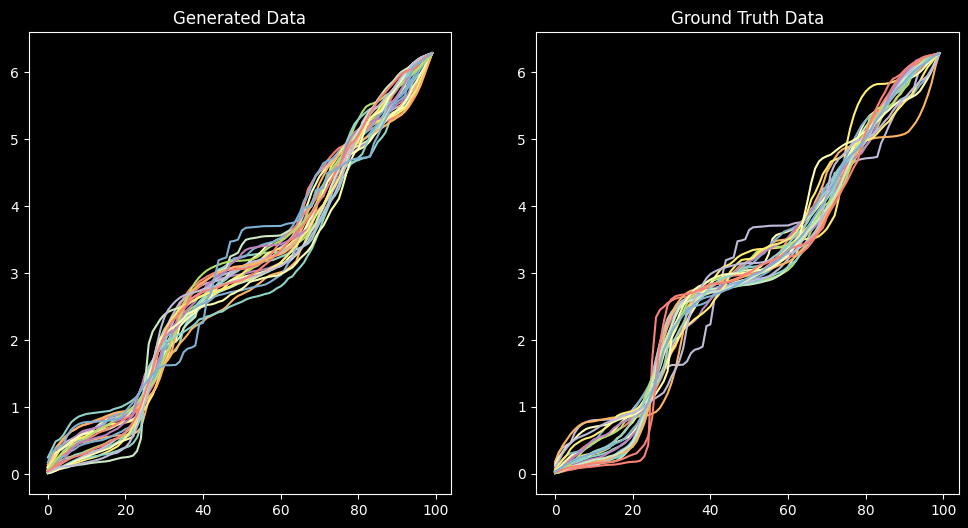

In [98]:
n = min(100, cw.shape[0])

# generated_data = h.view(-1, 100).cpu().detach().numpy()
generated_data = generate(num=n, sigma_vals=np.repeat(1, Z_DIM))
diff = 1 / (np.exp(generated_data) + 1e-8)
diff = diff / diff.sum(axis=1, keepdims=True) * 2 * np.pi
angle = np.cumsum(diff, axis=1)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax.title.set_text("Generated Data")
for i in range(angle.shape[0]):
    ax.plot(angle[i])

ground_truth = cw[np.random.choice(range(cw.shape[0]), n, replace=False)]
ground_truth_diff = 1 / (np.exp(ground_truth) + 1e-8)
ground_truth_diff = (
    ground_truth_diff / ground_truth_diff.sum(axis=1, keepdims=True) * 2 * np.pi
)
ground_truth_angle = np.cumsum(ground_truth_diff, axis=1)

ax = fig.add_subplot(122)
ax.title.set_text("Ground Truth Data")
for i in range(ground_truth_angle.shape[0]):
    ax.plot(ground_truth_angle[i])

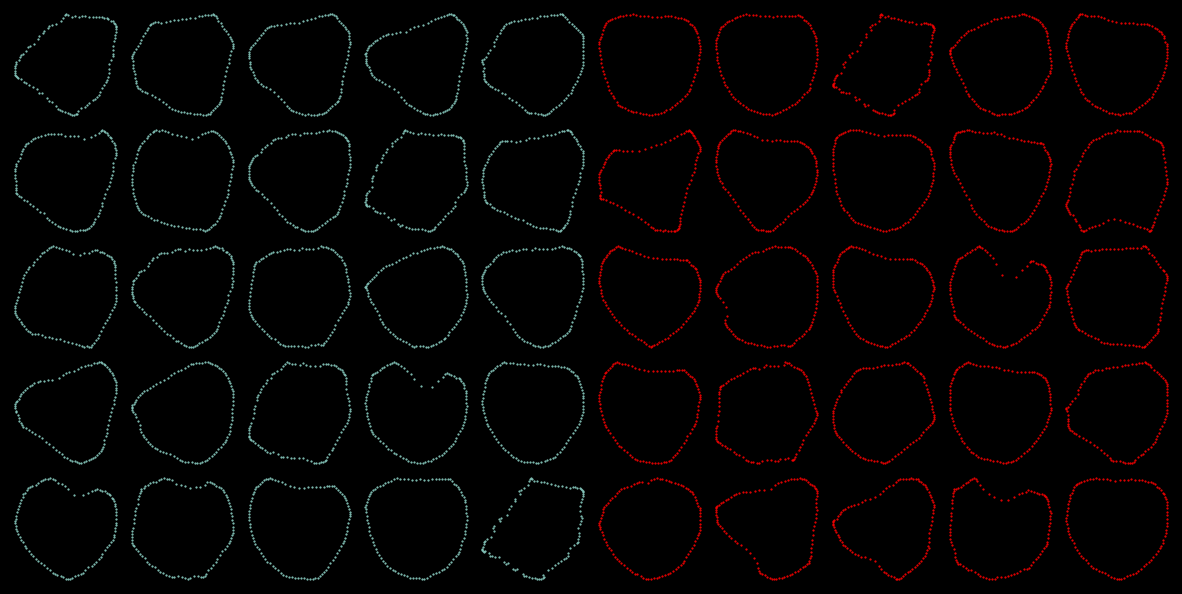

In [99]:
x = np.linspace(0, 2 * np.pi, INPUT_DIM + 1)[:INPUT_DIM]
xs = np.exp(1j * x)

x_num = 5
y_num = int(np.floor(2 * n / x_num))
subfigure_size = 1.5

fig = plt.figure(figsize=(2 * x_num * subfigure_size, y_num * subfigure_size))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# Blue for generated data
for i in range(n):
    ys = np.exp(1j * angle[i])
    try:
        r, _ = geodesicwelding(ys, [], ys, xs)
    except:
        pass
    k = i // x_num * 2 * x_num + i % x_num + 1
    plt.subplot(y_num, 2 * x_num, k)
    plt.scatter(r.real, r.imag, s=0.3)
    plt.axis("off")

# Red for ground truth data
for i in range(n):
    ys = np.exp(1j * ground_truth_angle[i])
    try:
        r, _ = geodesicwelding(ys, [], ys, xs)
    except:
        pass
    k = i // x_num * 2 * x_num + i % x_num + 1 + x_num
    plt.subplot(y_num, 2 * x_num, k)
    plt.scatter(r.real, r.imag, s=0.3, color="r")
    plt.axis("off")

Analysis

0.06283185307179587 0.07772378957038656


Text(0.5, 1.0, 'Original Distribution of Ground Truth ')

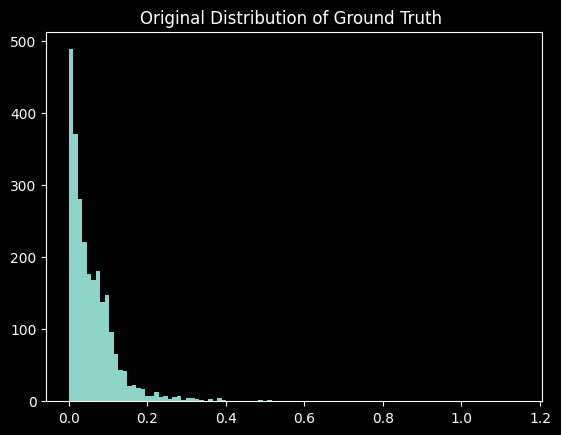

In [83]:
n = min(100, cw.shape[0])
c = cw[np.random.choice(range(cw.shape[0]), n, replace=False)]
p = 1 / np.exp(c)
print(p.mean(), p.std())
plt.hist(p.reshape(-1), bins=100)
plt.title("Original Distribution of Ground Truth ")

3.0427531755780746 0.8223316434324971


Text(0.5, 1.0, 'Distribution of Ground Truth Activated by 1/e^x')

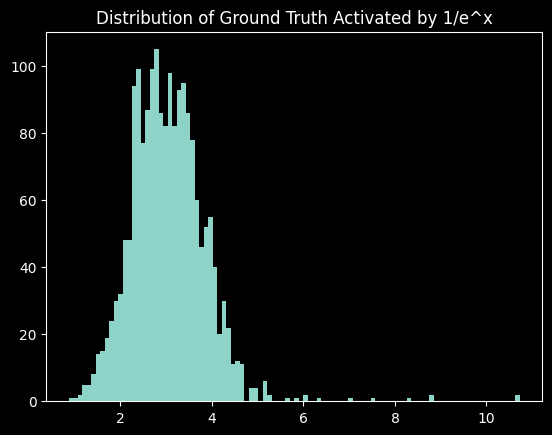

In [ ]:
c = cw[np.random.choice(range(cw.shape[0]), n, replace=False)]
print(c.mean(), c.std())
plt.hist(c.reshape(-1), bins=100)
plt.title("Distribution of Ground Truth Activated by 1/e^x")

tensor(3.0918, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.8098, device='cuda:0', grad_fn=<StdBackward0>)


Text(0.5, 1.0, 'Distribution of Generated Data')

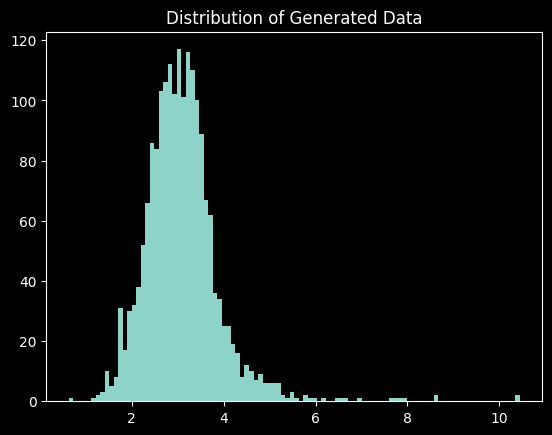

In [ ]:
# print(model.mean, model.std)
z = torch.randn(n, Z_DIM).to(DEVICE).view(n, 1, Z_DIM)
h = model.decode(z)
print(h.mean(), h.std())
# h = 1/torch.exp(h+1e-8)
# h = h / torch.sum(h, dim=1, keepdim=True) * 2 * torch.pi
plt.hist(h.cpu().detach().numpy().reshape(-1), bins=100)
plt.title("Distribution of Generated Data")